In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

from tensorflow.keras.layers import Input, Dense, Lambda, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import time
import psutil
import os
import pickle


In [ ]:
pip install shap

   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---------------------------------------- 549.1/549.1 kB 1.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ----------- ---------------------------- 0.8/2.7 MB 3.5 MB/s eta 0:00:01
   ---------------------- ----------------- 1.6/2.7 MB 3.2 MB/s eta 0:00:01
   ------------------------------ --------- 2.1/2.7 MB 3.2 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 3.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
    --------------------------------------- 0.5/38.1 MB 3.1 MB/s eta 0:00:12
   - -------------------------------------- 1.3/38.1 MB 3.3 MB/s eta 0:00:12
   - -------------------------------------- 1.6/38.1 MB 3.3 MB/s eta 0:00:12
   - -------------------------------------- 1.8/38.1 MB 2.8 MB/s eta 0:00:13
   -- ------------------------------------- 2.4/38.1 MB 2.3 MB/s eta 0:00:16
   -- ---------------


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/Khóa luận tốt nghiệp/Dataset/Dataset_CICIDS2017_sample_km.csv")

In [4]:
df_top13 = pd.read_csv("/content/drive/MyDrive/Khóa luận tốt nghiệp/Dataset/selected_features.csv")

In [5]:
X = df_top13.iloc[:, :-1]  # Các thuộc tính
y = df_top13.iloc[:, -1]   # Nhãn

In [6]:
X_all = df.iloc[:, :-1]
y_all = df.iloc[:, -1]

In [14]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, stratify=y_all, test_size=0.2, random_state=42)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# LỰA CHỌN THUỘC TÍNH

## Gini Importance

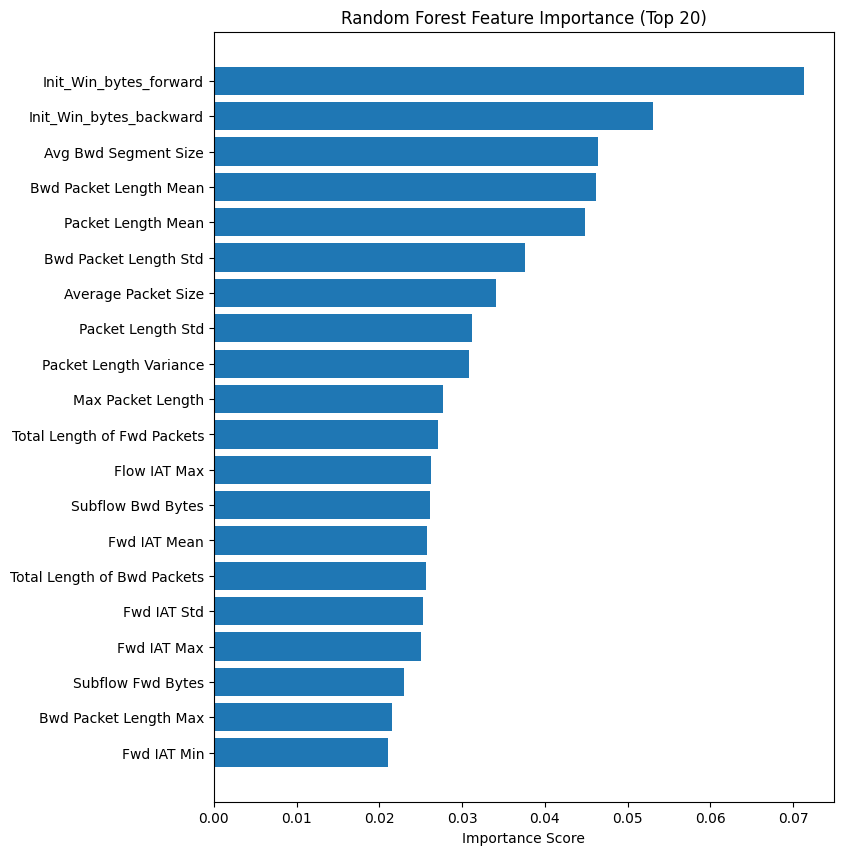

In [ ]:
# Huấn luyện mô hình RandomForest để tính mức độ quan trọng của từng thuộc tính
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Lấy độ quan trọng của từng thuộc tính
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Top 20
top_n = 20
top_features = X.columns[indices][:top_n]
top_scores = importances[indices][:top_n]
top20_rf = list(top_features)
pickle.dump(top20_rf, open("top20_rf.pkl", "wb"))

plt.figure(figsize=(8,10))
plt.barh(top_features[::-1], top_scores[::-1])
plt.title("Random Forest Feature Importance (Top 20)")
plt.xlabel("Importance Score")
plt.show()


## Permutation Importance

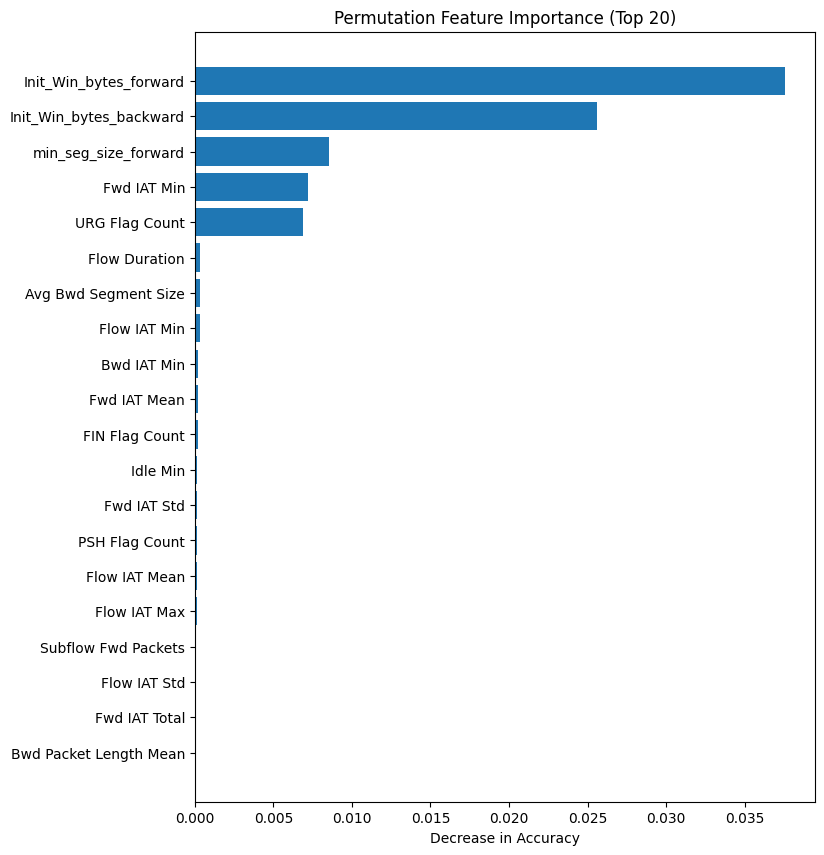

In [ ]:
from sklearn.inspection import permutation_importance
perm = permutation_importance(
    model, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

sorted_idx = perm.importances_mean.argsort()[::-1]
top20_perm = list(X.columns[sorted_idx][:20])
pickle.dump(top20_perm, open("top20_perm.pkl", "wb"))
plt.figure(figsize=(8,10))
plt.barh(X.columns[sorted_idx][:20][::-1],
         perm.importances_mean[sorted_idx][:20][::-1])
plt.title("Permutation Feature Importance (Top 20)")
plt.xlabel("Decrease in Accuracy")
plt.show()

## SHAP Values

                    Feature  Mean |SHAP Value|
21              Fwd IAT Std           0.017530
49           ECE Flag Count           0.010402
28              Bwd IAT Min           0.009883
63      Subflow Bwd Packets           0.009804
27              Bwd IAT Max           0.009077
35            Fwd Packets/s           0.008850
31            Fwd URG Flags           0.008358
7    Fwd Packet Length Mean           0.007785
66  Init_Win_bytes_backward           0.007088
26              Bwd IAT Std           0.007087
0             Flow Duration           0.006978
42           FIN Flag Count           0.006222
70               Active Std           0.005524
22              Fwd IAT Max           0.004860
38        Max Packet Length           0.004600
29            Fwd PSH Flags           0.004515
14           Flow Packets/s           0.004308
75                 Idle Max           0.004255
54      Fwd Header Length.1           0.004061
10    Bwd Packet Length Min           0.004013


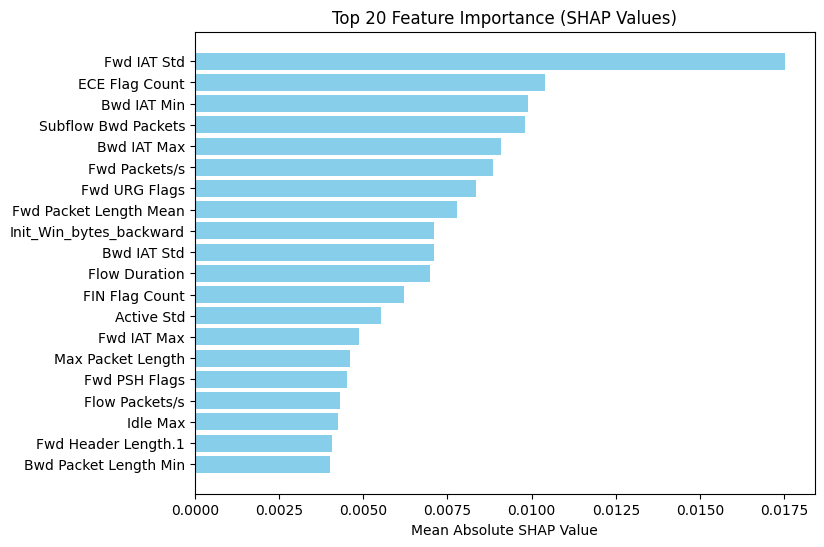

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Tính SHAP summary cho multi-class
if isinstance(shap_values, list):
    shap_summary = np.mean(np.abs(np.stack(shap_values)), axis=(0, 1))
else:
    shap_summary = np.abs(shap_values).mean(axis=0)

shap_summary = shap_summary.flatten()
shap_summary = shap_summary[:len(X_test.columns)]

# Tạo dataframe và chọn top 20
shap_summary_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean |SHAP Value|': shap_summary
}).sort_values('Mean |SHAP Value|', ascending=False)

top_20 = shap_summary_df.head(20)
top20_shap = list(top_20['Feature'])
pickle.dump(top20_shap, open("top20_shap.pkl", "wb"))
print(top_20)

plt.figure(figsize=(8, 6))
plt.barh(top_20['Feature'], top_20['Mean |SHAP Value|'], color='skyblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Top 20 Feature Importance (SHAP Values)')
plt.gca().invert_yaxis()
plt.show()

## Lấy ra top 10 thuộc tính

In [ ]:
# Lấy top 10 thuộc tính có độ quan trọng cao nhất
from collections import Counter
# top20_rf = pickle.load(open("top20_rf.pkl", "rb"))
# top20_perm = pickle.load(open("top20_perm.pkl", "rb"))
# top20_shap = pickle.load(open("top20_shap.pkl", "rb"))
combined = top20_rf + top20_perm + top20_shap
counts = Counter(combined)

# --- 5. Lấy features xuất hiện trong >=2 danh sách ---
final_features = [feat for feat, cnt in counts.items() if cnt >= 2]

print("Final Important Features (xuất hiện ≥ 2 phương pháp):")
print(final_features)
print("Số lượng:", len(final_features))

Final Important Features (xuất hiện ≥ 2 phương pháp):
['Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'Avg Bwd Segment Size', 'Bwd Packet Length Mean', 'Max Packet Length', 'Flow IAT Max', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Flow Duration', 'Bwd IAT Min', 'FIN Flag Count']
Số lượng: 13


In [ ]:
final_features_names = final_features
X_final = X[final_features_names]
X_all = X

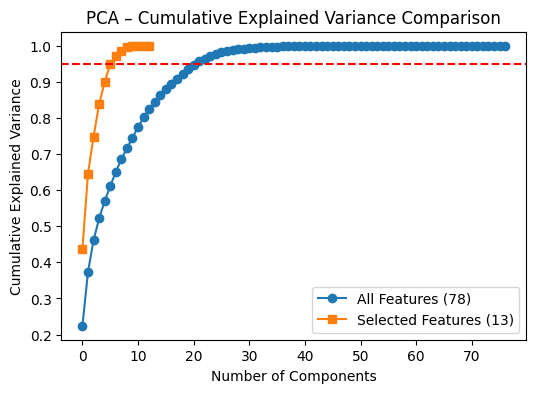

Components needed (78 features): 22
Components needed (13 features): 7


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# --- Chuẩn hóa ---
scaler = StandardScaler()

X_all_scaled = scaler.fit_transform(X_all)
X_final_scaled = scaler.fit_transform(X_final)

# --- PCA ---
pca_all = PCA().fit(X_all_scaled)
pca_final = PCA().fit(X_final_scaled)

cum_var_all = np.cumsum(pca_all.explained_variance_ratio_)
cum_var_final = np.cumsum(pca_final.explained_variance_ratio_)

# --- Vẽ so sánh ---
plt.figure(figsize=(6,4))
plt.plot(cum_var_all, label='All Features (78)', marker='o')
plt.plot(cum_var_final, label='Selected Features (13)', marker='s')
plt.axhline(0.95, linestyle='--', color='red')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA – Cumulative Explained Variance Comparison")
plt.legend()
plt.show()

# --- Số chiều đạt 95% variance ---
n_all = np.argmax(cum_var_all >= 0.95) + 1
n_final = np.argmax(cum_var_final >= 0.95) + 1

print("Components needed (78 features):", n_all)
print("Components needed (13 features):", n_final)


## Hàm dùng để đánh giá sự ảnh hướng của top 10 thuộc tính lên accuracy, thời gian thực thi, bộ nhớ khi train trên XGBoost và RandomForest

In [ ]:
#Tắt các cảnh báo (warning)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=Warning)

<h3> Top 13 đặt trưng </h3>


===== XGBoost =====


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:00:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[10 trees] Acc=0.9897 | Time=0.2431s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:00:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[20 trees] Acc=0.9931 | Time=0.4229s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:00:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[30 trees] Acc=0.9946 | Time=0.6296s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:00:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[40 trees] Acc=0.9951 | Time=0.7689s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:00:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[50 trees] Acc=0.9953 | Time=0.8953s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:00:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[60 trees] Acc=0.9953 | Time=1.1045s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:00:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[70 trees] Acc=0.9953 | Time=3.9889s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:00:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[80 trees] Acc=0.9953 | Time=1.3242s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:00:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[90 trees] Acc=0.9953 | Time=1.5054s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:00:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[100 trees] Acc=0.9953 | Time=1.6260s

📄 Classification Report (XGB – Final model):
              precision    recall  f1-score   support

           0     0.9962    0.9973    0.9967      3645
           1     0.9949    0.9924    0.9936       393
           2     1.0000    0.7895    0.8824        19
           3     0.9902    0.9984    0.9943       609
           4     1.0000    0.7143    0.8333         7
           5     0.9881    0.9960    0.9921       251
           6     1.0000    0.9908    0.9954       436

    accuracy                         0.9953      5360
   macro avg     0.9956    0.9255    0.9554      5360
weighted avg     0.9954    0.9953    0.9953      5360



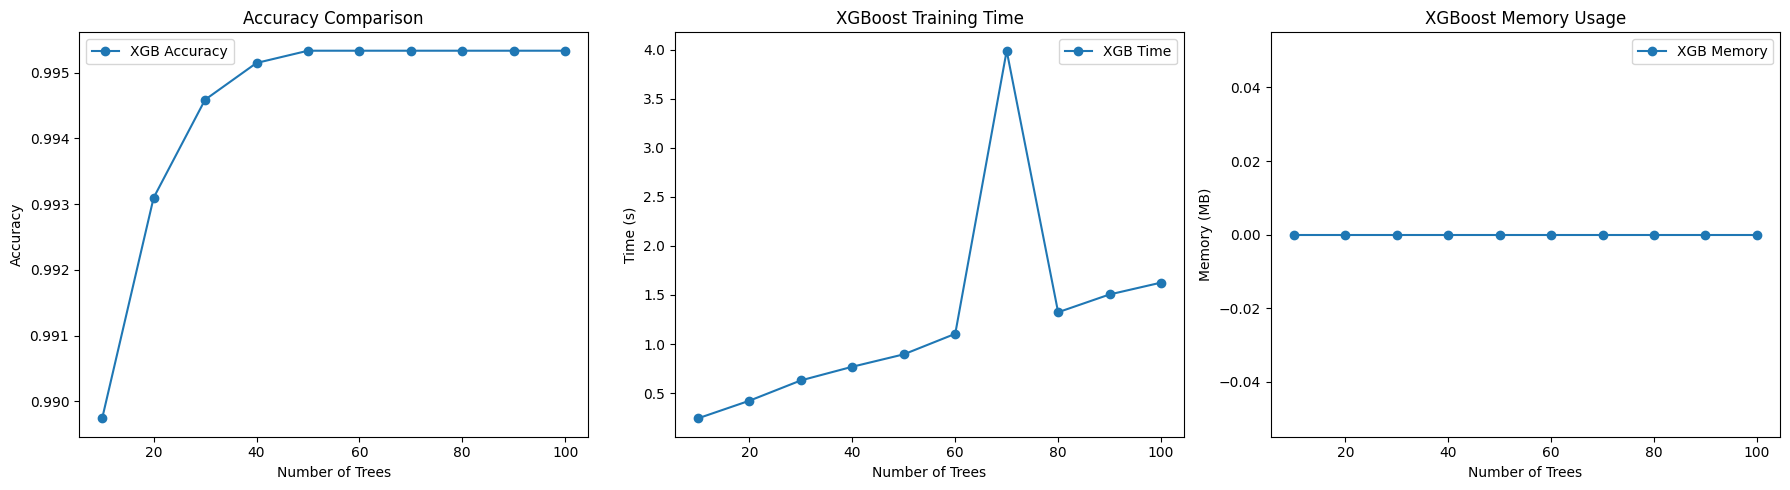

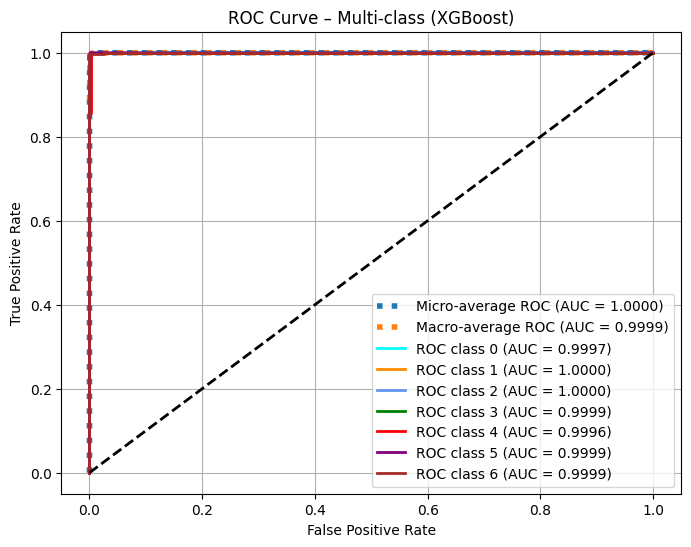

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import psutil
from itertools import cycle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import label_binarize


# ---  XGBoost theo số cây (thay epoch) ---
print("\n===== XGBoost =====")
estimators_range = np.arange(10, 101, 10)
xgb_accs, xgb_times, xgb_mems = [], [], []

for n in estimators_range:
    start_mem = psutil.Process().memory_info().rss / 1024**2
    start_time = time.time()

    xgb_model = XGBClassifier(
        n_estimators=n,
        objective="multi:softprob",
        eval_metric="mlogloss",
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False
    )
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)

    end_time = time.time()
    end_mem = psutil.Process().memory_info().rss / 1024**2

    acc = accuracy_score(y_test, y_pred_xgb)
    xgb_accs.append(acc)
    xgb_times.append(end_time - start_time)
    xgb_mems.append(end_mem - start_mem)

    print(f"[{n} trees] Acc={acc:.4f} | Time={end_time - start_time:.4f}s")

print("\n📄 Classification Report (XGB – Final model):")
print(classification_report(y_test, y_pred_xgb, digits=4))

# --- 5. Vẽ Accuracy / Time / Memory ---
plt.figure(figsize=(18, 5))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(estimators_range, xgb_accs, marker='o', label='XGB Accuracy')
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")
plt.legend()

# Time
plt.subplot(1, 3, 2)
plt.plot(estimators_range, xgb_times, marker='o', label='XGB Time')
plt.xlabel("Number of Trees")
plt.ylabel("Time (s)")
plt.title("XGBoost Training Time")
plt.legend()

# Memory
plt.subplot(1, 3, 3)
plt.plot(estimators_range, xgb_mems, marker='o', label='XGB Memory')
plt.xlabel("Number of Trees")
plt.ylabel("Memory (MB)")
plt.title("XGBoost Memory Usage")
plt.legend()

plt.tight_layout()
plt.show()

# --- 6. ROC Curve Multi-class (XGBoost) ---
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)
y_score = xgb_model.predict_proba(X_test)

fpr, tpr, roc_auc = {}, {}, {}

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(classes)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(classes)
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"], linestyle=':', linewidth=4,
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})')
plt.plot(fpr["macro"], tpr["macro"], linestyle=':', linewidth=4,
         label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.4f})')

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])
for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC class {classes[i]} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Multi-class (XGBoost)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


===== Random Forest =====
Accuracy : 0.9925
⏱ Thời gian train: 5.9025s
📊 Memory usage : 22.95 MB

📄 Classification Report (RF – Final model):
              precision    recall  f1-score   support

           0     0.9929    0.9964    0.9947      3645
           1     0.9873    0.9924    0.9898       393
           2     1.0000    0.7895    0.8824        19
           3     0.9918    0.9901    0.9910       609
           4     1.0000    0.8571    0.9231         7
           5     0.9843    0.9960    0.9901       251
           6     1.0000    0.9725    0.9860       436

    accuracy                         0.9925      5360
   macro avg     0.9938    0.9420    0.9653      5360
weighted avg     0.9926    0.9925    0.9925      5360



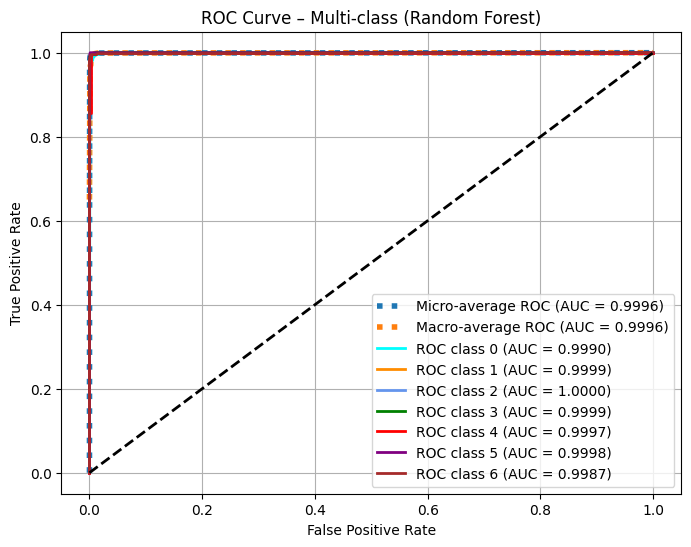

In [17]:
# --- Random Forest ---
print("\n===== Random Forest =====")

import psutil, time

start_mem = psutil.Process().memory_info().rss / 1024**2
start_time = time.time()

rf_model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

end_time = time.time()
end_mem = psutil.Process().memory_info().rss / 1024**2

rf_acc = accuracy_score(y_test, y_pred_rf)

print(f"Accuracy : {rf_acc:.4f}")
print(f"⏱ Thời gian train: {end_time - start_time:.4f}s")
print(f"📊 Memory usage : {end_mem - start_mem:.2f} MB")

print("\n📄 Classification Report (RF – Final model):")
print(classification_report(y_test, y_pred_rf, digits=4))

# --- ROC Curve Multi-class (Random Forest) ---
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)
y_score = rf_model.predict_proba(X_test)

fpr, tpr, roc_auc = {}, {}, {}

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(classes)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(classes)
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"], linestyle=':', linewidth=4,
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})')
plt.plot(fpr["macro"], tpr["macro"], linestyle=':', linewidth=4,
         label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.4f})')

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])
for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC class {classes[i]} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Multi-class (Random Forest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

<h3> Tất cả đặt trưng </h3>


===== XGBoost =====


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:02:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[10 trees] Acc=0.9922 | Time=0.7967s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:02:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[20 trees] Acc=0.9953 | Time=1.3349s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:02:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[30 trees] Acc=0.9972 | Time=1.8375s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:02:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[40 trees] Acc=0.9976 | Time=2.3017s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:02:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[50 trees] Acc=0.9976 | Time=5.5941s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:02:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[60 trees] Acc=0.9974 | Time=3.2656s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:02:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[70 trees] Acc=0.9970 | Time=3.6291s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:02:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[80 trees] Acc=0.9968 | Time=6.7695s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:02:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[90 trees] Acc=0.9970 | Time=4.3859s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:02:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[100 trees] Acc=0.9972 | Time=4.9022s

📄 Classification Report (XGB – Final model):
              precision    recall  f1-score   support

           0     0.9981    0.9981    0.9981      3645
           1     0.9949    0.9949    0.9949       393
           2     1.0000    1.0000    1.0000        19
           3     0.9951    0.9967    0.9959       609
           4     1.0000    0.8571    0.9231         7
           5     0.9881    0.9960    0.9921       251
           6     1.0000    0.9954    0.9977       436

    accuracy                         0.9972      5360
   macro avg     0.9966    0.9769    0.9860      5360
weighted avg     0.9972    0.9972    0.9972      5360



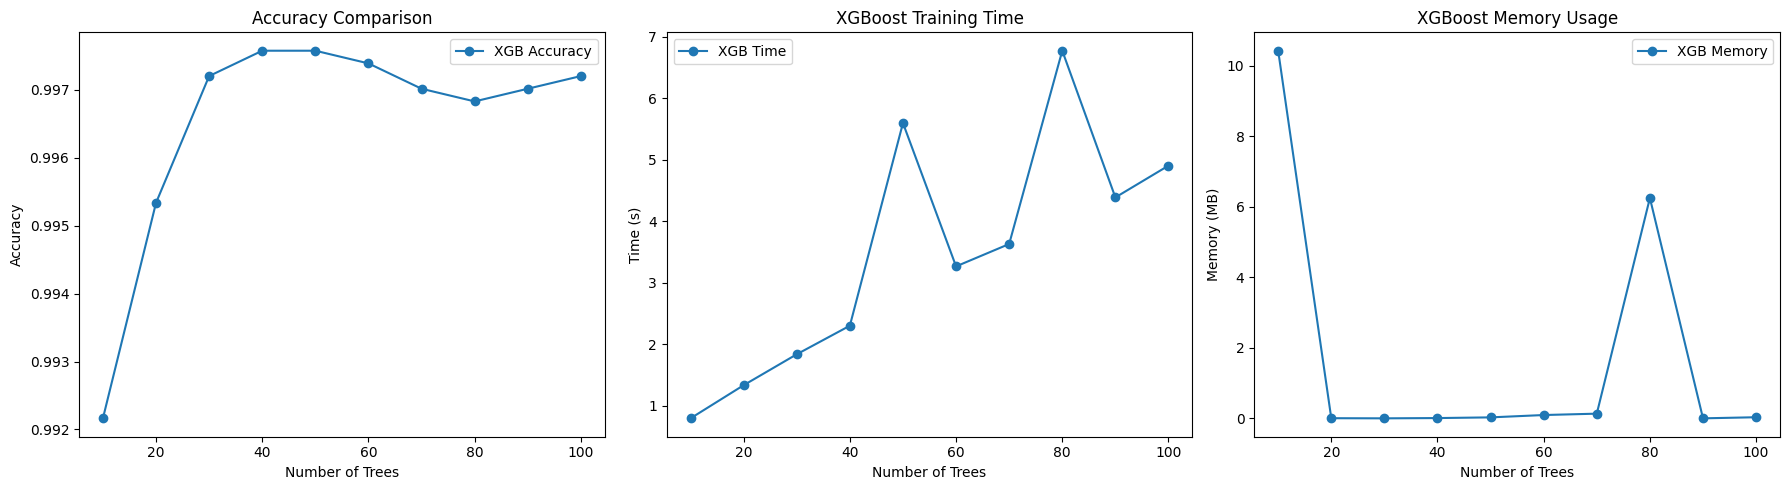

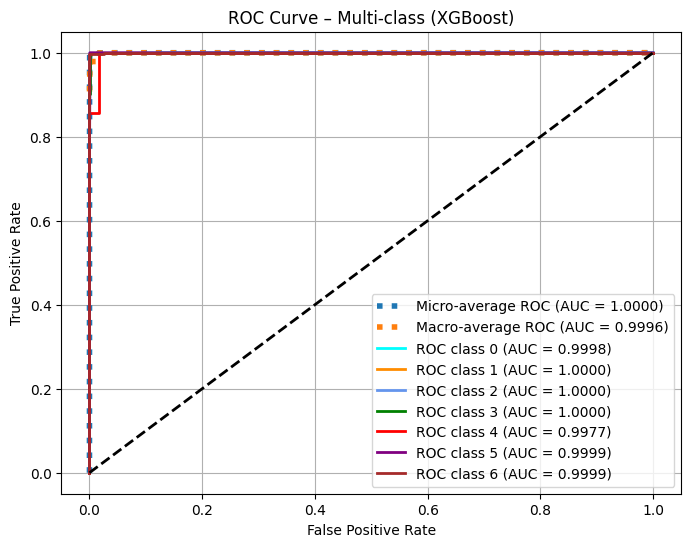

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import psutil
from itertools import cycle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import label_binarize


# ---  XGBoost theo số cây (thay epoch) ---
print("\n===== XGBoost =====")
estimators_range = np.arange(10, 101, 10)
xgb_accs, xgb_times, xgb_mems = [], [], []

for n in estimators_range:
    start_mem = psutil.Process().memory_info().rss / 1024**2
    start_time = time.time()

    xgb_model = XGBClassifier(
        n_estimators=n,
        objective="multi:softprob",
        eval_metric="mlogloss",
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False
    )
    xgb_model.fit(X_train_all, y_train_all)
    y_pred_xgb = xgb_model.predict(X_test_all)

    end_time = time.time()
    end_mem = psutil.Process().memory_info().rss / 1024**2

    acc = accuracy_score(y_test_all, y_pred_xgb)
    xgb_accs.append(acc)
    xgb_times.append(end_time - start_time)
    xgb_mems.append(end_mem - start_mem)

    print(f"[{n} trees] Acc={acc:.4f} | Time={end_time - start_time:.4f}s")

print("\n📄 Classification Report (XGB – Final model):")
print(classification_report(y_test_all, y_pred_xgb, digits=4))

# --- 5. Vẽ Accuracy / Time / Memory ---
plt.figure(figsize=(18, 5))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(estimators_range, xgb_accs, marker='o', label='XGB Accuracy')
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")
plt.legend()

# Time
plt.subplot(1, 3, 2)
plt.plot(estimators_range, xgb_times, marker='o', label='XGB Time')
plt.xlabel("Number of Trees")
plt.ylabel("Time (s)")
plt.title("XGBoost Training Time")
plt.legend()

# Memory
plt.subplot(1, 3, 3)
plt.plot(estimators_range, xgb_mems, marker='o', label='XGB Memory')
plt.xlabel("Number of Trees")
plt.ylabel("Memory (MB)")
plt.title("XGBoost Memory Usage")
plt.legend()

plt.tight_layout()
plt.show()

# --- 6. ROC Curve Multi-class (XGBoost) ---
classes = np.unique(y_train_all)
y_test_all_bin = label_binarize(y_test_all, classes=classes)
y_score = xgb_model.predict_proba(X_test_all)

fpr, tpr, roc_auc = {}, {}, {}

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_all_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_all_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(classes)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(classes)
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"], linestyle=':', linewidth=4,
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})')
plt.plot(fpr["macro"], tpr["macro"], linestyle=':', linewidth=4,
         label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.4f})')

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])
for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC class {classes[i]} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Multi-class (XGBoost)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Kết luận

## Tạo bộ dữ liệu mới có tên là selected_features.csv lưu trữ tất cả các dòng dữ liệu với 13 cột features và 1 cột label.

In [ ]:
top_10_features = final_features

label_column = "Label"   # đổi đúng tên cột nhãn của dataset nếu khác

# Kiểm tra cột hợp lệ (phòng tránh lỗi phức tạp)
valid_columns = [col for col in top_10_features + [label_column] if col in df.columns]

# Lọc dataset gồm các features quan trọng + label
df_selected = df.loc[:, valid_columns]

print("Shape của dữ liệu đã chọn:", df_selected.shape)

df_selected.to_csv("D:/KHÓA LUẬN TỐT NGHIỆP/DATASET/selected_features.csv",index=False)

Shape của dữ liệu đã chọn: (26800, 14)


In [ ]:
#Lấy dữ liệu đã tạo
df_data = pd.read_csv("D:/KHÓA LUẬN TỐT NGHIỆP/DATASET/selected_features.csv")

## Tỉ lệ phân bố giữa dữ liệu bình thường và malware ban đầu trong tập dữ liệu.

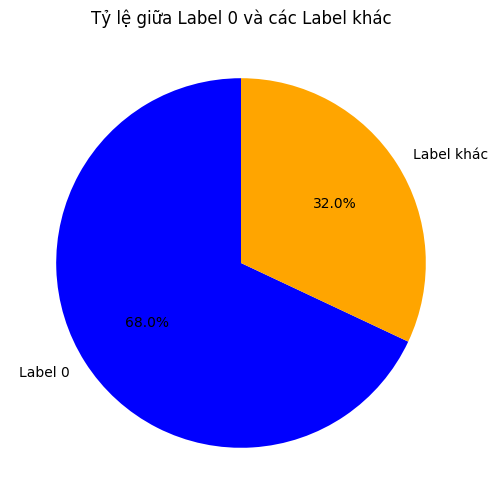

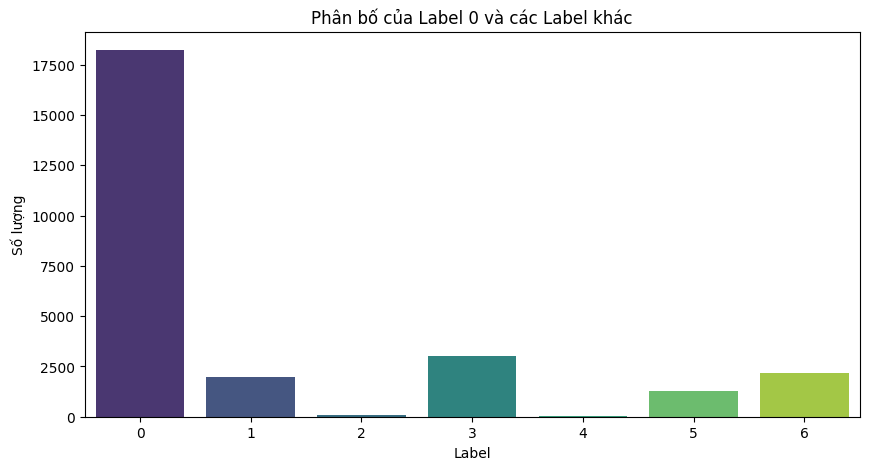

In [ ]:
#Tỉ lệ lệnh bình thường và malware của tập dữ liệu

# Đếm số lượng mỗi loại label
label_counts = df_data['Label'].value_counts()

# Gộp tất cả các label khác 0 thành một nhóm
label_counts_grouped = {
    "Label 0": label_counts.get(0, 0),
    "Label khác": label_counts.sum() - label_counts.get(0, 0)
}

# Vẽ biểu đồ tròn
plt.figure(figsize=(8, 6))
plt.pie(label_counts_grouped.values(), labels=label_counts_grouped.keys(), autopct='%1.1f%%', colors=['blue', 'orange'], startangle=90)
plt.title('Tỷ lệ giữa Label 0 và các Label khác')
plt.show()

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.xlabel('Label')
plt.ylabel('Số lượng')
plt.title('Phân bố của Label 0 và các Label khác')
plt.show()
